In [1]:

import pandas as pd
import numpy as np 
import re , datetime , logging, pickle, os
from lib.config import connstr
from lib.utils import * 
from lib.question_type_recommender import question_type_recommender
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore') 
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  
import shap 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from lib.context import context

import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()

ctx=context() 
ctx.logger.setLevel(logging.DEBUG)
config = {}
with open('config.json', 'r') as f: 
    config=json.loads(f.read())    
ctx.config=config 

c:\Users\timko\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
test='If no, please provide an explanation of how your organization is storing, collecting, and processing technical indicators across your enterprise.'
test='Provide any additional information on the effectiveness (positive or negative) of the organization’s risk management program that was not noted in the questions above. Taking into consideration the overall maturity level generated from the questions above and based on all testing performed, is the risk management program effective'




In [6]:
qr = question_type_recommender(ctx, verbose=True, use_cache=True)
qt=qr.recommend(test)
qt

{'PK_QuestionType': 2, 'Code': 'CNT'}

In [2]:
sns.set(rc={'figure.figsize':(18,4.7)}) 
plt.style.use('Solarize_Light2') # fivethirtyeight

In [5]:
codes = ['YN','CNT','TXT','PICK','FREQ','DEC','MULTICHECKBOX' ]
qt=sql_todf(f"""
SELECT PK_QuestionTypeId, Code ,description FROM fsma_QuestionTypes
  WHERE Code IN ('YN','CNT','YNA','TXT','PICK','LABEL','FREQ','DEC','MULTICHECKBOX')
    """, connstr)   

df=sql_todf(f"""
    SELECT PK_Question, FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('{"','".join(codes)}')  
    -- AND PK_Question < 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)  

def _normalizer(s):
    s=re.sub('[^a-z0-9\s\-\?]','',s.lower().strip() )
    s=re.sub('\s{2,}',' ',s)
    return s 
_normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
#qt
# df[df['Code'].isin(['FREQ','DEC'])]
df['QuestionText']=df['QuestionText'].apply(_normalizer)    

<AxesSubplot:>

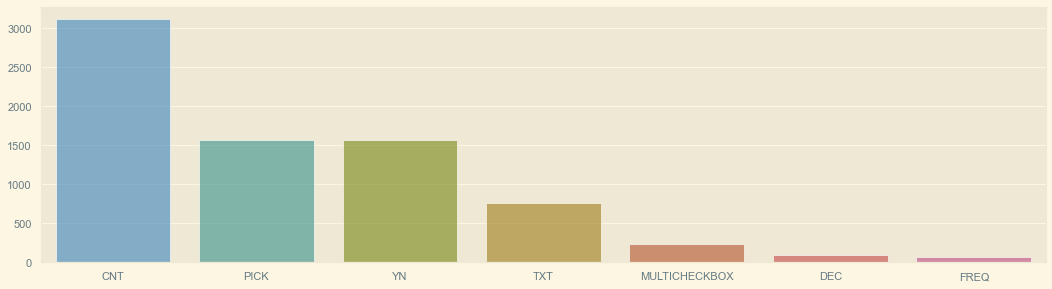

In [6]:
sns.barplot(df['Code'].value_counts().index, df['FK_QuestionType'].value_counts().values, alpha=0.6) 

In [20]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=.003, analyzer='word',token_pattern=u'\w+|\?' )    
X = vectorizer.fit_transform(df['QuestionText'])   
sparse_matrix = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
sparse_matrix=pd.merge(df, sparse_matrix, left_index=True, right_index=True)  
sparse_matrix.drop(['QuestionText', 'PK_Question', 'Code' ], inplace=True, axis=1) 
sparse_matrix

,FK_QuestionType,01,02,03,04,04 25,06,07,07 16,1,...,yet created,yet created nor,you,your,your agency,your agency have,your agencys,your organization,your own,your own device
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7406,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
7407,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
7408,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7409,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [21]:
model = LogisticRegression(max_iter=200) 
 
X_train, X_test, y_train, y_test = train_test_split( sparse_matrix.drop(['FK_QuestionType' ], axis=1).values ,  sparse_matrix['FK_QuestionType'].values  , random_state=1)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=model.score(X_test, y_test) 
score

0.9546681057744199

In [ ]:
 
df['QuestionText']=df['QuestionText'].apply(_normalizer)  
model = LogisticRegression(max_iter=200) 
lod=[]
for ng in [ (1,3), (1,4)   ]: # ,  , (1,3), (1,4) (1,2), 
    for i in range(1,3,1): # 0.002
        start = datetime.datetime.now()
        mindf = i*.001   
        vectorizer = CountVectorizer(ngram_range=ng, min_df=mindf, analyzer='word',token_pattern=u'\w+|\?')
        
        X = vectorizer.fit_transform(df['QuestionText'])   
        sparse_matrix = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
        sparse_matrix=pd.merge(df, sparse_matrix, left_index=True, right_index=True)  
        sparse_matrix.drop(['QuestionText', 'PK_Question', 'Code' ], inplace=True, axis=1) 
        y = sparse_matrix['FK_QuestionType'].values 
        X = sparse_matrix.drop(['FK_QuestionType' ], axis=1).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)
        score=model.score(X_test, y_test) 
        stop = datetime.datetime.now()
        report = classification_report(y_test, y_pred, target_names=codes)
        d={
            'score':score,
            'time': (stop-start).seconds,
            'ngram_range': ng,
            'min_df': mindf,
            'sparse_matrix.shape':sparse_matrix.shape,
            'report':report
        }
        print(d)  
        lod.append(d)
scores = pd.DataFrame(lod)


In [ ]:
print( scores.loc[0, 'report'] )  
scores.sort_values(by='score')
if len(scores) > 1:
    sns.lineplot(data=scores, x='time', y='score' )

In [22]:
from sklearn.model_selection import GridSearchCV
params =  { 
    'max_iter': [50, 200, 1000]
} 
grid = GridSearchCV(estimator=model,  param_grid=params, cv=10,  n_jobs=1) 
grid.fit(X_train, y_train) 
grid.best_score_, grid.best_params_

(0.9489023916002333, {'max_iter': 50})

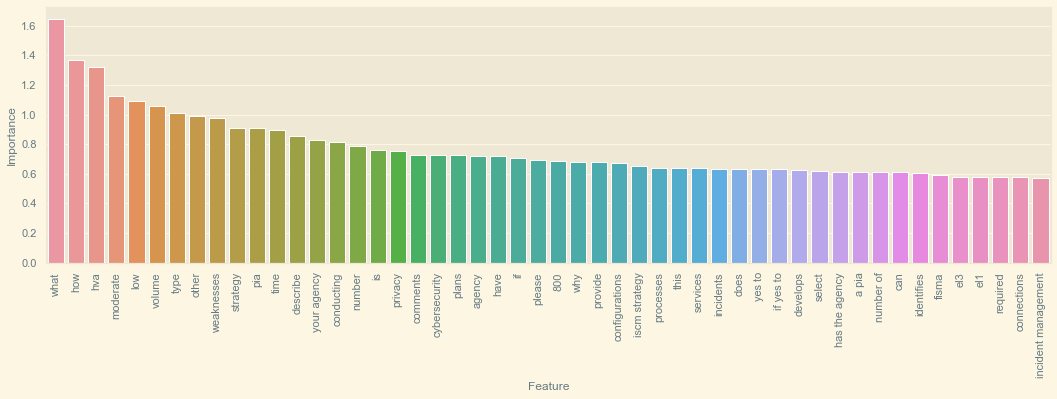

In [16]:
coefficients = abs(model.coef_[0])
coefficients[0]
fi = pd.DataFrame({'Feature': sparse_matrix.columns[1:], 'Importance': coefficients})
fi = fi.sort_values('Importance', ascending=False)   
plot = sns.barplot(x=fi[:50].Feature , y=fi[:50].Importance) 
plt.xticks(rotation=90)
plt.show() 

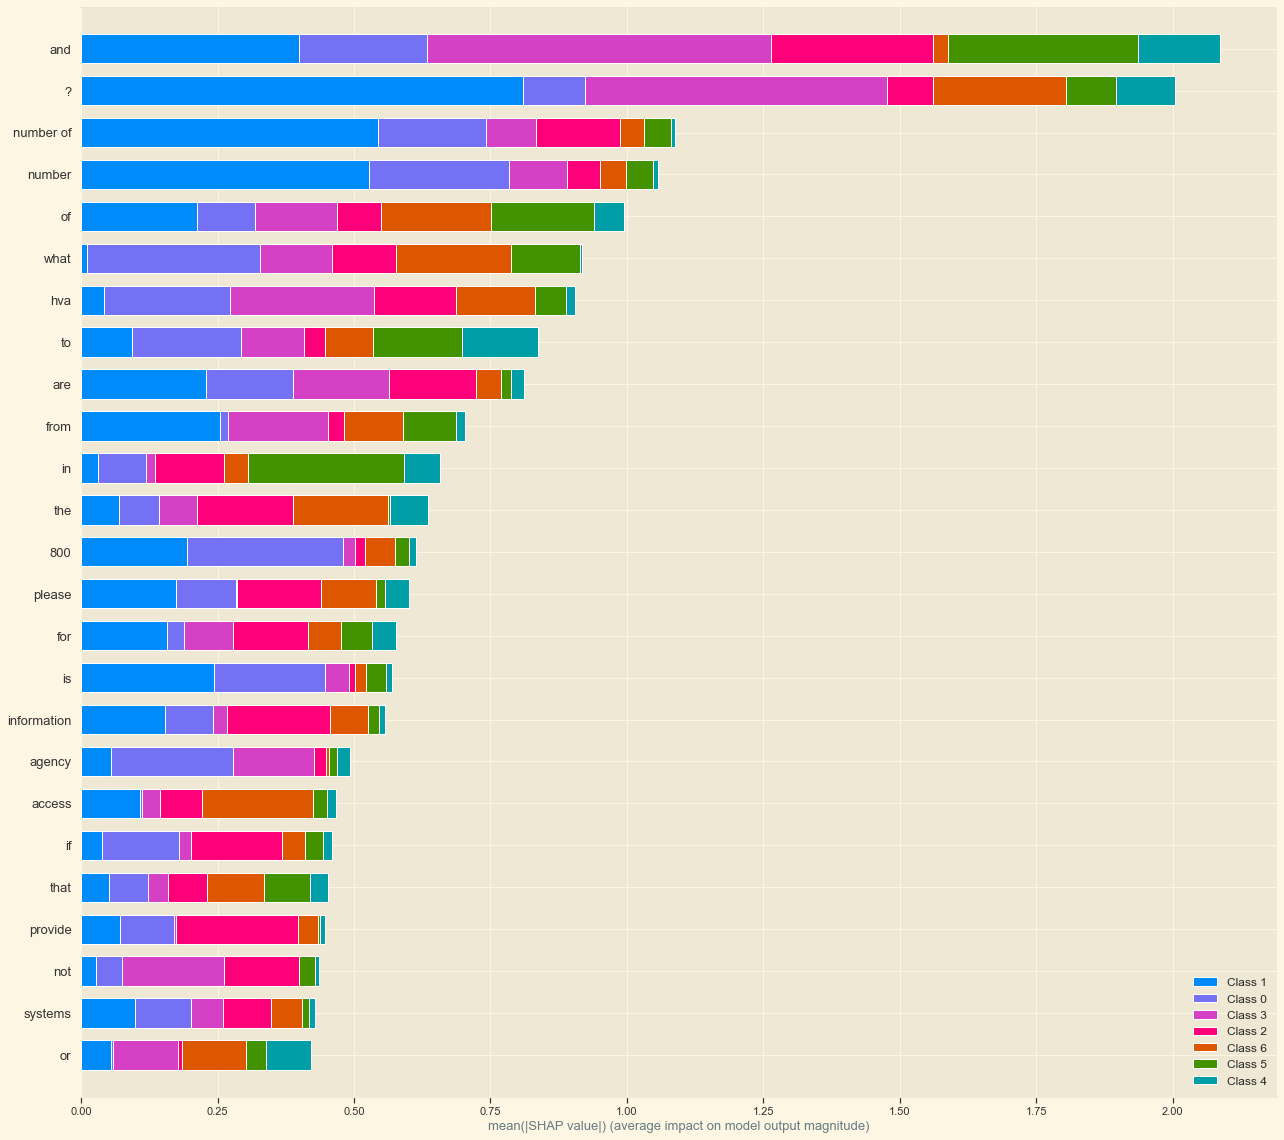

In [17]:
explainer = shap.Explainer(model, X_test )
shap_values = explainer.shap_values(X_test)   
shap.summary_plot( shap_values,  X_test, max_display=25,  feature_names=sparse_matrix.columns[1:],  plot_size=[18,16] ) 

In [ ]:

df1=sql_todf(f"""
    SELECT  FK_QuestionType, Code, QuestionText 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ('YN', 'CNT', 'TXT', 'PICK', 'FREQ', 'DEC', 'MULTICHECKBOX') --  'YNA', 'FREQ','DEC',
    AND PK_Question > 40000
    ORDER BY PK_QUESTION DESC
    """, connstr)
print(codes)

In [ ]:
lod=[]
for i,r in df1.iterrows():
    rec = qr.recommend(r['QuestionText'])
    if str(r['FK_QuestionType']) != str(rec):
        d={
            'actual': r['FK_QuestionType'],
            'rec': rec,
            'QuestionText': r['QuestionText']
        }
        lod.append(d)
dff=pd.DataFrame(lod)


In [ ]:
d17 = dff.loc[dff.actual == 17]
d17.to_csv('out/data.csv')

In [ ]:
txt=_normalizer('How many threat model exercises [34] were conducted in the last reporting period ?')
print(txt)
X = vectorizer.transform([txt])  
prediction=model.predict(X.toarray())
print ('\nPK_QuestionType : '+ str(prediction[0])) 

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots()
tick_marks = np.arange(len(codes))
plt.xticks(tick_marks, codes)
plt.yticks(tick_marks, codes) 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g' , xticklabels=codes, yticklabels=codes) 
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
def sm_predict(s,threshold=.25): 
    s=_normalizer(s)
    print ( s )
    dfff=df.copy()
    for i,r in dfff.iterrows():  
        normed = _normalizer(r['QuestionText'] )
        ratio=SequenceMatcher(None, s, normed).ratio() 
        dfff.loc[i, 'ratio'] = ratio
        #if ratio > threshold: break
    d=dfff.loc[dfff.ratio > threshold]
    d=d.sort_values(by=['ratio'], ascending=False) 
    return d
dfp=sm_predict("""

   Is there an internet-facing method to access the system?
    """)
dfp

In [ ]:

def _normalizer(s):
    s=re.sub('[^a-z0-9\s\-\?]','',s.lower().strip() )
    s=re.sub('\s{2,}',' ',s)
    s=' '.join([ ps.stem(s) for s in s.split(' ')])
    return s 
_normalizer('Has the Agency implemented an automated capability to detect and block unauthorized hardware from connecting to the network?' )

In [ ]:
df=sql_todf(f"""
    SELECT  QuestionText, CAST(FK_PickListType AS NVARCHAR(9)) Y -- FK_QuestionType, Code, 
    FROM fsma_Questions 
	  INNER JOIN fsma_QuestionTypes ON fsma_Questions.FK_QuestionType=fsma_QuestionTypes.PK_QuestionTypeId
	  WHERE FK_QuestionType IS NOT NULL AND QuestionText IS NOT NULL  
    AND Code IN ( 'PICK',  'MULTICHECKBOX') 
    AND FK_PickListType IN (124,157,162,168,330,423,85,88,89,97)
    ORDER BY PK_QUESTION DESC
    """, connstr)
df['QuestionText']=df['QuestionText'].apply(_normalizer)
df=df.sort_values('QuestionText').drop_duplicates(subset=['Y', 'QuestionText'], keep='last')
pk1=df[:-500]
pk2=df[500:]
df.Y.value_counts()


In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0, stop_words='english', analyzer='word' ) 
X = vectorizer.fit_transform(df['QuestionText'])   
vectorizer.get_feature_names() 
X 

In [ ]:
sparse_matrix = pd.DataFrame(columns=vectorizer.get_feature_names(), data=X.toarray()) 
sparse_matrix=pd.merge(df, sparse_matrix, left_index=True, right_index=True)  
sparse_matrix.drop(['QuestionText'], inplace=True, axis=1) 
y = sparse_matrix['Y'].values 
features = sparse_matrix.drop(['Y'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=1)

In [ ]:
from sklearn import svm
model= LogisticRegression()
# model = svm.SVC()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score=model.score(X_test, y_test) 
report = classification_report(y_test, y_pred )


In [ ]:
print(score)
print ( report ) 

In [ ]:
txt=_normalizer("Did you evaluate iDP sources as described in the guidance? Did you harden SSO feature as described in the guidance? Did you turn on advanced logging and establish a PAM baseline(Expected privileged account state) for Cloud?")
print(txt)
X = vectorizer.transform([txt])  
prediction=model.predict(X.toarray())
print ('\nprediction: '+ str(prediction[0])) 



In [ ]:
explainer = shap.Explainer(model, X_test )
shap_values = explainer.shap_values(X_test)   
shap.summary_plot( shap_values,  X_test, max_display=25,  feature_names=sparse_matrix.columns[1:],  plot_size=[18,16] ) 